## *Seminar 6: Constant Elasticity of Variance (CEV)*

## 1. CEV model

#### 1.1 SDE

In CEV model the spot dynamics is given by the following SDE:

$$dS_t = (r - q)S_t dt + \sigma S_t^{\beta} dW_t, \qquad S_0 = s > 0,$$

where $\beta > 0.$

The leverage function $\sigma(s) = \sigma s^{\beta - 1}$ is decreasing in $s$ if $\beta < 1$ and increasing if $\beta > 1$. 

Recall that if $\beta \in (0, 1)$, then the process $S_t$ reaches $0$ with positive probability. If $\beta > 1$, the process $S_t$ is strictly positive. 

Also, if $\beta \in (0, 1)$ the process $S_t$ is a martingale, if $\beta > 1$ is only a local martingale. 



#### 1.2 CEV time change

The CEV process with non-zero drift $\mu$ (i.e. $\mu \neq 0$) can be obtained from the process without drift ($\mu = 0$) via a scale and time change:

$$S_t^{(\mu)} = e^{\mu t} S_{\tau(t)}^{0}, \quad \tau(t) = \frac{e^{2 \mu (\beta - 1) t} - 1}{2 \mu (\beta - 1)}.$$

Hence, without loss of generality in case of determistic interest rates and dividend yields we can deal with the model given by a SDE

$$dS_t = \sigma S_t^{\beta} dW_t, \quad S_0 = s.$$

#### 1.3 CEV Options Pricing

The closed-form CEV call option pricing formula with strike $K$, time to expiration $T$, and the initial asset price $S$ can be obtained in closed form by integrating the call payoff with the risk-neutral CEV density with the riskneutral drift $\mu = r - q$ ($r$ is the risk-free interest rate and $q$ is the dividend yield). The result can be expressed in terms of the complementary noncentral chi-square distribution function $Q(z; v, k)$

$$C(T, K; S)= e^{-rT} \mathbb{E}^{\mathbb{Q}} [ (S_T - K)_+ | S_0 = S] = $$
$$= \begin{cases} e^{-qT} S Q(\xi; 2\nu, y_0)- e^{-rT} K(1 - Q(y_0; 2(1 + \nu), \xi)), \quad \beta > 1 \\

e^{-qT} S Q(\xi; 2( 1 + |\nu|), y_0)- e^{-rT} K(1 - Q(y_0; 2|\nu|, \xi)), \quad 0 < \beta < 1
\end{cases},$$

where 

$$\xi = \dfrac{2 \mu S^{2(1 - \beta)}}{\sigma^2 (1 - \beta) (1 - e^{2 \mu (\beta - 1)T})}, \quad y_0 = \dfrac{2 \mu K^{2 (1 - \beta)}}{\sigma^2 (1 - \beta) (e^{2 \mu (1 - \beta) T} - 1)}, \quad \nu = \frac{1}{2 (\beta - 1)},$$

and $Q(z; v, k)$ is the complementary noncentral chi-square distribution function which can be expressed as the series of complementary Gamma distribution functions

$$Q(z; v, k) = \sum_{n=0}^{\infty} e^{-k/2} \frac{(k/2)^n}{\Gamma(n + 1)} G \left( n + \frac{\nu}{2}; \frac{z}{2} \right), \qquad k, z > 0$$

where $G(\nu, x) = 1 / \Gamma(\nu) \int_{x}^{\infty} u^{v - 1}e^{-u} du$ and $\Gamma(\nu) = \int_{0}^{\infty} u^{v - 1} e^{-u} du.$


The prices of the puts can be expressed from the put-call parity, i.e. 

$$P(T, K; S) = C(T, K; S) + Ke^{-rT} - Se^{-qT}.$$

In [22]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
from typing import Union
from scipy import optimize
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
implied_volatility_vec = np.vectorize(implied_volatility)


In [24]:
def black_scholes(s: float, sigma: float, r: float, q: float, 
                  t: Union[float, np.ndarray], k: Union[float, np.ndarray], is_call: bool):
    """
    Returns th Black-Sscholes option's price. 

    Args:
        s (float): spot price S_0. 
        sigma (float): volatility \sigma. 
        r (float): interest rate.
        q (float): dividend yield.
        t (float): time to expiration. 
        k (float): strike. 
        is_call (bool): True if call, False if Put. 
    """
    d_1 = ((np.log(s / k) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t)))
    d_2 = d_1 - sigma * np.sqrt(t)
    call_price = (s * np.exp(-q * t) * st.norm.cdf(d_1) - np.exp( - r * t) * k * st.norm.cdf(d_2))

    if is_call:
        return call_price
    
    return call_price + k * np.exp( - r * t) - s * np.exp(- q * t)

In [25]:
def iv_black_scholes(price: Union[float, np.ndarray], S: float, 
                     K: Union[float, np.ndarray], t: Union[float, np.ndarray], 
                     r: float, is_call: bool):
    """
    Returns implied volatility from given options' prices. 
   
    """
    return implied_volatility_vec(price=price, S=S, K=K, t=t, r=r, flag='c' if is_call else 'p') 

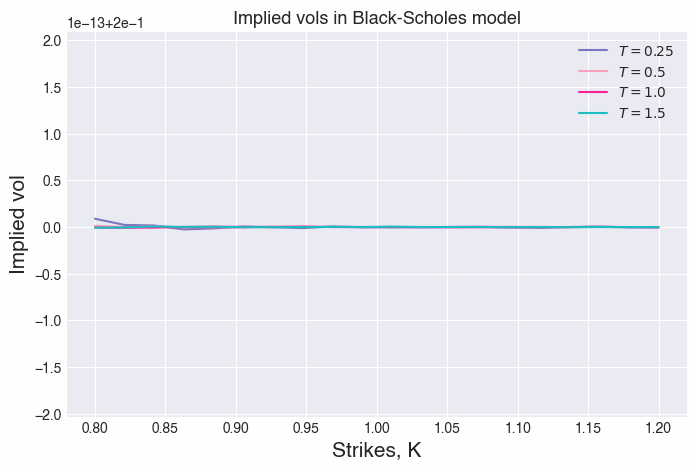

In [27]:
s = 1; sigma = 0.2; r = 0.05; q = 0.0; is_call=True
strikes = np.linspace(0.8, 1.2, 20)
times = np.array([0.25, 0.5, 1, 1.5])

prices_bs = np.zeros((times.size, strikes.size))
ivs_bs = np.zeros((times.size, strikes.size))
for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    prices_bs[:, i] = black_scholes(s=s, sigma=sigma, r=r, q=q, t=times, k=strike, is_call=is_call)
    ivs_bs[:, i] = iv_black_scholes(price=prices_bs[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, time in enumerate(times):
    plt.plot(strikes, ivs_bs[i, :], label="$T={}$".format(times[i]))

plt.title("Implied vols in Black-Scholes model", fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

In [28]:
def to_zero_drift(t: Union[float, np.ndarray], k: Union[float, np.ndarray], 
                  mu: float, beta: float):
    """
    Adjusts the spot and time variables to zero-drift setup.

    Args:
        t: time.
        k: spot, strike, etc.
        mu: risk-neutral drift, i.e. r - q. 
        beta: \beta of the CEV model. 
    """
    if mu == 0:
        return t, k
    t_adj = (np.exp(2 * mu * (beta - 1) * t) - 1)/ (2 * mu * (beta - 1))
    k_adj = np.exp(-mu * t) * k
    
    return t_adj, k_adj

In [29]:
def constant_elasticity_of_variance(s, sigma, beta, r, q, t, k, is_call):
    """
    Returns th CEV option's price. 

    Args:
        s (float): spot price S_0. 
        sigma (float): volatility \sigma. 
        beta (float): \beta of teh CEV model. 
        r (float): interest rate.
        q (float): dividend yield.
        t (float): time to expiration. 
        k (float): strike. 
        is_call (bool): True if call, False if Put. 
    """
    if np.isclose(beta, 1, rtol=0, atol=1e-12):
        return black_scholes(s, sigma, r, q, t, k, is_call)

    nu = 0.5 / (beta - 1)
    t_adj, k_adj = to_zero_drift(t, k, r - q, beta)
    xi = s ** (2 * (1 - beta)) / ((sigma * (1 - beta)) ** 2 * t_adj)
    y = k_adj ** (2 * (1 - beta)) / ((sigma * (1 - beta)) ** 2 * t_adj)

    if beta < 1:
        call_price = (s * st.ncx2(2*(1 - nu), xi).sf(y) - k_adj*st.ncx2(-2 * nu, y).cdf(xi))
    else:
        call_price = (s * st.ncx2(2 * nu, y).sf(xi) - k_adj * st.ncx2(2 * (1 + nu), xi).cdf(y))

    if is_call:
        return call_price
    return  call_price + k * np.exp( - r * t) - s * np.exp(- q * t)

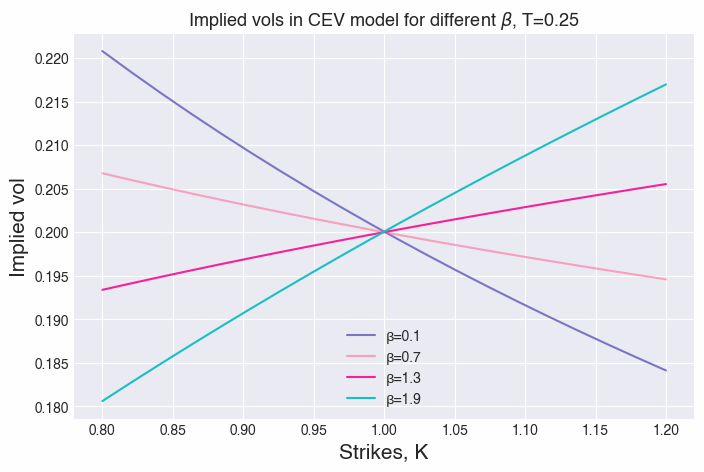

In [31]:
betas = np.linspace(0.1, 1.9, 10)
prices_cev = np.zeros((betas.size, times.size, strikes.size))
ivs_cev = np.zeros((betas.size, times.size, strikes.size))

for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    for j, beta in enumerate(betas):
        prices_cev[j, :, i] = constant_elasticity_of_variance(s=s, sigma=sigma, beta=betas[j], r=r, q=q, t=times, k=strike, is_call=is_call)
        ivs_cev[j, :, i] = iv_black_scholes(price=prices_cev[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for j, beta in enumerate(betas):
    if j % 3 == 0:
        plt.plot(strikes, ivs_cev[j, 0, :], label="β={}".format(round(beta, 2)))

plt.title("Implied vols in CEV model for different $\\beta$, T={}".format(times[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)


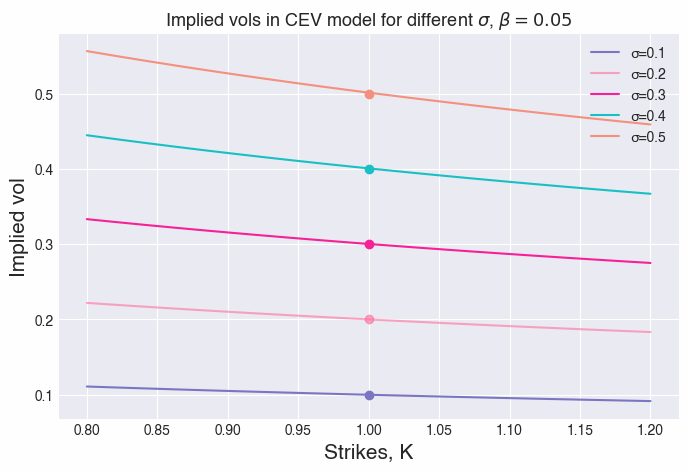

In [32]:
sigmas = np.linspace(0.1, 0.5, 5)
beta = 0.05
prices_cev_diff_sigmas = np.zeros((sigmas.size, times.size, strikes.size))
ivs_cev_diff_sigmas = np.zeros((sigmas.size, times.size, strikes.size))

for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    for j, sigma in enumerate(sigmas):
        prices_cev_diff_sigmas[j, :, i] = constant_elasticity_of_variance(s=s, sigma=sigma, beta=beta, r=r, q=q, t=times, k=strike, is_call=is_call)
        ivs_cev_diff_sigmas[j, :, i] = iv_black_scholes(price=prices_cev_diff_sigmas[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for j, _ in enumerate(sigmas):
    plt.plot(strikes, ivs_cev_diff_sigmas[j, 0, :], label="σ={}".format(round(sigmas[j], 2)))
    plt.scatter(s, sigmas[j])

plt.title("Implied vols in CEV model for different $\sigma$, $β={}$".format(beta), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

#### 1.4 Hagan-Woodward IV Approximation

$$\sigma_{IV}(T, K) = \dfrac{\sigma}{\tilde f^{1 - \beta}} \left( 1 + \dfrac{(1 - \beta)(2 + \beta))}{24} \left(\dfrac{\tilde f - K}{\tilde f}\right)^2 + \dfrac{(1 - \beta)^2}{24}\dfrac{\sigma^2 T}{\tilde f^{2(1 - \beta)}} + ...\right),$$

where $\tilde f = (F_0 + K) / 2$ and $F_0$ is a forward on $T$. 

In [45]:
def iv_from_approximation(s, sigma, beta, r, q, t, k):
    """
    Returns the IV from Hagan-Woodward formula.

    Args:
        s (float): spot price S_0. 
        sigma (float): volatility \sigma. 
        beta (float): \beta of teh CEV model. 
        r (float): interest rate.
        q (float): dividend yield.
        t (float): time to expiration. 
        k (float): strike. 
    """
    t_adj, k_adj = to_zero_drift(t, k, r - q, beta)
    f = 0.5 * (s + k_adj)
    return np.sqrt(t_adj / t) * (
        sigma * f ** (beta - 1) * 
        (1 + (1 - beta) * (2 + beta) / 24 * ((s - k_adj) / f) ** 2 +
        (1 - beta) ** 2 / 24 * sigma ** 2 * t_adj * f ** (2 * (beta - 1))))

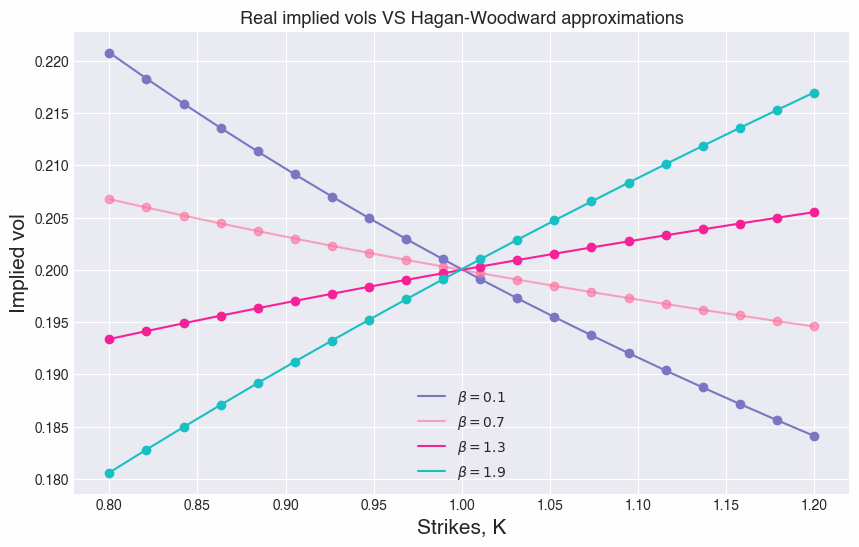

In [46]:
betas = np.linspace(0.1, 1.9, 10)
ivs_cev_approx = np.zeros((betas.size, times.size, strikes.size))
sigma=0.2

for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    for j, beta in enumerate(betas):
        ivs_cev_approx[j, :, i] = iv_from_approximation(s=s, sigma=sigma, beta=betas[j], r=r, q=q, t=times, k=strike)

plt.figure(figsize=(10, 6))
for j, beta in enumerate(betas):
    if j % 3 == 0:
        plt.plot(strikes, ivs_cev_approx[j, 0, :], label="$β={}$".format(beta))
        plt.scatter(strikes, ivs_cev[j, 0, :])

plt.title("Real implied vols VS Hagan-Woodward approximations".format(beta), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

#### 1.5 Sticky local vol volatility dynamics

CEV model (as a local volatility model) produces a specific dynamics of implied volatility. That is, if $S_{t + \Delta t} > S_{t}$, then implied volatility curve shifts left, which can be uncommon on financial markets.

In [47]:
ivs_cev_wrong_dynamcis = np.zeros((3, times.size, strikes.size))
s_moves = [s - s * 0.03, s, s + s * 0.03]
beta = 0.5

for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    for j, s_move in enumerate(s_moves):
        ivs_cev_wrong_dynamcis[j, :, i] = iv_from_approximation(s=s_move, sigma=sigma, beta=beta, r=r, q=q, t=times, k=strike)

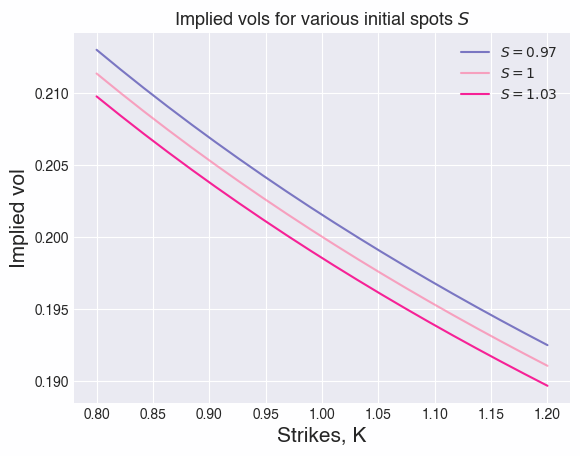

In [48]:
for j, _ in enumerate(s_moves):
    plt.plot(strikes, ivs_cev_wrong_dynamcis[j, 0, :], label="$S={}$".format(s_moves[j]))

plt.title("Implied vols for various initial spots $S$".format(beta), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

#### 1.6 Calibration

In [49]:
def objective_function(
        x: tuple[float, float],
        s: float,
        r: float,
        q: float, 
        t: Union[float, np.ndarray],
        k: np.ndarray,
        iv: np.ndarray
    ) -> float:
        """The objective function for parameter calibration.

        Computes the sum of squares of differences between the model and market
        implied volatilities, for each expiration time and strike.

        Args:
            x: Tuple of calibrated parameters `(sigma, beta)`.
            s: Initial price.
            r: Interest rate.
            t: Array of expiration times.
            k: Array of strikes.
            iv: Array of market implied volatilities for each combination of
            expiration time and strike, i.e. with shape `(len(t), len(k))`. May
            contain NaNs, which are ignored when computing the sum of squares.
        """
        return sum((iv_from_approximation(s=s, sigma=x[0], beta=x[1], r=r, q=q, t=t[i], k=k[i]) - iv[i])**2
                   for i in range(len(iv)))

In [50]:
def calibrate(
        t: Union[float, np.ndarray],
        k: np.ndarray,
        iv: np.ndarray,
        s: float,
        r: float = 0,
        q: float = 0,
        min_method: str = "L-BFGS-B",
        beta0 = 0.8
    ):
        """Calibrates the parameters of the CEV model.

        This function finds the parameters `sigma` and `beta` of the model
        which minimize the sum of squares of the differences between market
        and model implied volatilities. Returns an instance of the class with
        the calibrated parameters.

        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv: Array of market implied volatilities.
            s: Initial price.
            r: Interest rate.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
            beta0: Initial guess of parameter `beta` (see notes below).
        """
        k_ = k.flatten()
        iv_ = iv.flatten()
        if isinstance(t, float):
            t_ = np.ones_like(k_) * t
        else:
            t_ = t.flatten()
        sigma0 = iv_[np.abs(k_ - s).argmin()]

        res = optimize.minimize(
            fun=objective_function,
            x0=(sigma0, beta0),
            bounds=[(0, np.inf), (0, np.inf)],
            args=(s, r, q, t_, k_, iv_),
            method=min_method)

        return res.x        

In [51]:
strikes_data, call_price_data = np.loadtxt("data-sem-6.txt", skiprows=1, delimiter=",", unpack=True)

In [53]:
strikes_data, call_price_data

(array([0.6    , 0.65714, 0.71429, 0.77143, 0.82857, 0.88571, 0.94286,
        1.     , 1.05714, 1.11429, 1.17143, 1.22857, 1.28571, 1.34286,
        1.4    ]),
 array([0.40115, 0.34568, 0.29161, 0.24036, 0.19369, 0.15124, 0.115  ,
        0.0845 , 0.06046, 0.04207, 0.02815, 0.01941, 0.01236, 0.00725,
        0.00446]))

In [54]:
s = 1.0; t = 0.25; r = 0; q = 0
implied_vol_data = np.zeros(strikes_data.size)

price_data = call_price_data
is_call = strikes_data > s
price_data[~is_call] = call_price_data[~is_call] + strikes_data[~is_call] * np.exp(-r * t) - s * np.exp(-q * t)

for i, strike in enumerate(strikes_data):
    implied_vol_data[i] = iv_black_scholes(price=price_data[i], S=s, K=strike, t=t, r=r, is_call=is_call[i])

In [55]:
implied_vol_data

array([0.48279547, 0.47068577, 0.45530073, 0.44608411, 0.444026  ,
       0.43575304, 0.43100476, 0.42441518, 0.4201772 , 0.41663291,
       0.41134499, 0.41516559, 0.41038668, 0.40091124, 0.39929127])

In [56]:
sigma_calibr, beta_calibr = calibrate(t, strikes_data, implied_vol_data, s, r, q)

In [57]:
calibrated_iv = iv_from_approximation(s=s, sigma=sigma_calibr, beta=beta_calibr, r=r, q=q, t=t, k=strikes_data)

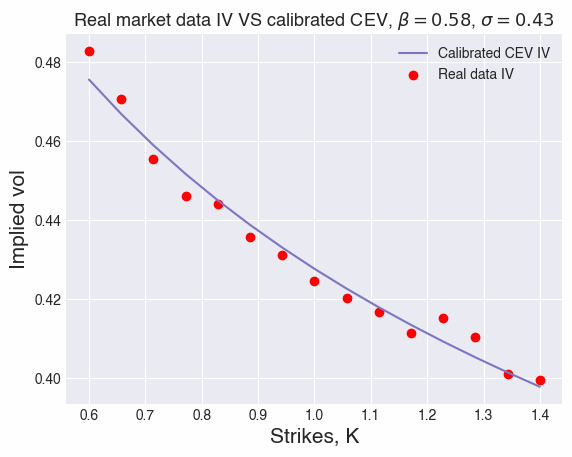

In [58]:
plt.plot(strikes_data, calibrated_iv, label="Calibrated CEV IV")
plt.scatter(strikes_data, implied_vol_data, label="Real data IV", color="r")

plt.title("Real market data IV VS calibrated CEV, $\\beta={}$, $\\sigma={}$".format(round(beta_calibr, 2), round(sigma_calibr, 2)), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

#### 1.7 Disadvatanges of CEV model and potential extensions

1. Vanilla option formula depends on an infinite series of Gamma functions or evalutaion of non-central chi-squared distribution function, which is difficult to compute accurately and quickly. 

2. The $\beta$ parameter values required to match market-observable implied volatility skews are often
near zero, and always less than 1. Hence, implied volatilities for high strikes become very small or even converge to zero.

3. For calibrated values of $\beta$, the solution of SDE can attain zero, which may lead to numerical inconvenience and even undefined payoff of a derivative contract.

4. Ito's lemme does not hold for any $f(S)$ for $\beta < 1$. Hence, it can be difficult to perform any transformation of an underlying variable to homogeneous scale near zero. 

Potential workaround for numerical instabilities near zero values can be a displaced diffusion model

$$dS_t = \sigma_{DD} (\beta S_t + (1 - \beta)S_0) dW_t.$$

Hence,  Black-Scholes model can be applied directly with transformation $S_t \to \beta S_t + (1 - \beta)S_0$. Moreover, implied volatility for high strikes for the displaced diffusion model converges to $\sigma_{DD} \beta$ and not to zero. 

However, the displaced diffusion model for $\beta < 0$ still allows zero to be attained, even negative values for S are possible!

To tackle with all problems alltogether, the Hyperbolic local volatility model can be used. 

#### 1.8 References

1. Vadim Linetsky & Rafael Mendozaz, **The Constant Elasticity of Variance Model**, 2009, https://api.semanticscholar.org/CorpusID:153292161

2. Peter Jaeckel, **Hyperbolic local volatility**, 2006, http://www.jaeckel.org/HyperbolicLocalVolatility.pdf

3. M. Rubinstein. **Displaced diffusion option pricing**. Journal of Finance, 1983.